In [5]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

root = 'D:/datasets/inputs'

train_dir = Path(f'{root}/training/training/')
test_dir = Path(f'{root}/validation/validation/')

In [6]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
label_df = pd.read_csv(f"{root}/monkey_labels.txt", names=cols, skiprows=1)
label_df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [7]:
labels = label_df['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [8]:
def image_show(num_image,label):
    from matplotlib import pyplot as plt
    import random
    import cv2
    import os
    for i in range(num_image):
        imgdir = Path(f'{root}/training/training/' + label)
        imgfile = random.choice(os.listdir(imgdir))
        img = cv2.imread(f'{root}/training/training/'+ label +'/'+ imgfile)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

 pygmy_marmoset                


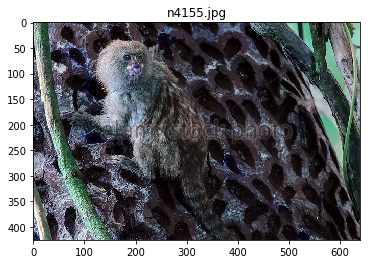

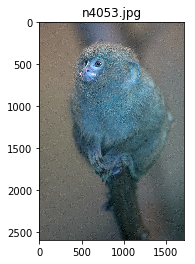

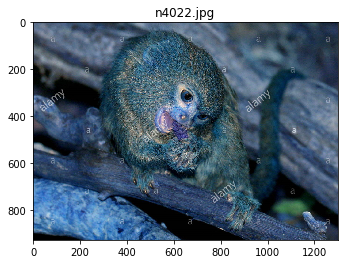

In [9]:
print(labels[4])
image_show(3,'n4')

## 数据预处理

In [10]:
from keras.preprocessing.image import ImageDataGenerator

height = 150
width = 150
batch_size = 64
seed = 100

# Training generator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


## 建立模型

In [27]:
def get_net(num_classes):
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (1,1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(num_classes, (1,1)))
    model.add(GlobalAvgPool2D())
    model.add(Activation('softmax'))

    return model

In [28]:
num_classes = 10
net = get_net(num_classes)
net.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
activation_34 (Activation)   (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
activation_35 (Activation)   (None, 36, 36, 32)        0         
__________

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath=("models/monkey.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

epochs = 200

history = net.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/200
17/17 [==============================] - 35s 2s/step - loss: 2.0695 - acc: 0.2835 - val_loss: 1.7692 - val_acc: 0.3781

Epoch 00001: val_acc improved from -inf to 0.37811, saving model to models/monkey.h5f
Epoch 2/200
17/17 [==============================] - 37s 2s/step - loss: 1.7730 - acc: 0.3902 - val_loss: 2.2045 - val_acc: 0.2148

Epoch 00002: val_acc did not improve from 0.37811
Epoch 3/200
17/17 [==============================] - 37s 2s/step - loss: 1.6458 - acc: 0.4430 - val_loss: 1.9508 - val_acc: 0.3125

Epoch 00003: val_acc did not improve from 0.37811
Epoch 4/200
17/17 [==============================] - 35s 2s/step - loss: 1.5428 - acc: 0.4821 - val_loss: 1.4804 - val_acc: 0.4922

Epoch 00004: val_acc improved from 0.37811 to 0.49219, saving model to models/monkey.h5f
Epoch 5/200
17/17 [==============================] - 36s 2s/step - loss: 1.5169 - acc: 0.4805 - val_loss: 1.6664 - val_acc: 0.3789

Epoch 00005: val_acc did not improve from 0.49219
Epoch 6/200
17/

17/17 [==============================] - 35s 2s/step - loss: 0.6233 - acc: 0.7930 - val_loss: 1.0079 - val_acc: 0.6328

Epoch 00043: val_acc did not improve from 0.78516
Epoch 44/200
17/17 [==============================] - 37s 2s/step - loss: 0.6065 - acc: 0.8041 - val_loss: 0.8490 - val_acc: 0.6797

Epoch 00044: val_acc did not improve from 0.78516
Epoch 45/200
17/17 [==============================] - 33s 2s/step - loss: 0.6293 - acc: 0.7787 - val_loss: 0.8090 - val_acc: 0.6875

Epoch 00045: val_acc did not improve from 0.78516
Epoch 46/200
17/17 [==============================] - 35s 2s/step - loss: 0.5596 - acc: 0.8198 - val_loss: 0.6948 - val_acc: 0.7383

Epoch 00046: val_acc did not improve from 0.78516
Epoch 47/200
17/17 [==============================] - 35s 2s/step - loss: 0.5883 - acc: 0.8073 - val_loss: 0.8121 - val_acc: 0.7383

Epoch 00047: val_acc did not improve from 0.78516
Epoch 48/200
17/17 [==============================] - 33s 2s/step - loss: 0.6336 - acc: 0.8082 - v


Epoch 00086: val_acc did not improve from 0.91797
Epoch 87/200
17/17 [==============================] - 34s 2s/step - loss: 0.3014 - acc: 0.9127 - val_loss: 0.5056 - val_acc: 0.8164

Epoch 00087: val_acc did not improve from 0.91797
Epoch 88/200
17/17 [==============================] - 35s 2s/step - loss: 0.3932 - acc: 0.8854 - val_loss: 0.7983 - val_acc: 0.7305

Epoch 00088: val_acc did not improve from 0.91797
Epoch 89/200
17/17 [==============================] - 36s 2s/step - loss: 0.3569 - acc: 0.8778 - val_loss: 0.5064 - val_acc: 0.8438

Epoch 00089: val_acc did not improve from 0.91797
Epoch 90/200
17/17 [==============================] - 35s 2s/step - loss: 0.3059 - acc: 0.9110 - val_loss: 0.3283 - val_acc: 0.8906

Epoch 00090: val_acc did not improve from 0.91797
Epoch 91/200
17/17 [==============================] - 36s 2s/step - loss: 0.3317 - acc: 0.9016 - val_loss: 1.1388 - val_acc: 0.6641

Epoch 00091: val_acc did not improve from 0.91797
Epoch 92/200
17/17 [==============

17/17 [==============================] - 35s 2s/step - loss: 0.1044 - acc: 0.9679 - val_loss: 0.2955 - val_acc: 0.8789

Epoch 00174: val_acc did not improve from 0.97656
Epoch 175/200
17/17 [==============================] - 37s 2s/step - loss: 0.1573 - acc: 0.9544 - val_loss: 0.2575 - val_acc: 0.9353

Epoch 00175: val_acc did not improve from 0.97656
Epoch 176/200
17/17 [==============================] - 36s 2s/step - loss: 0.1691 - acc: 0.9306 - val_loss: 0.5124 - val_acc: 0.7969

Epoch 00176: val_acc did not improve from 0.97656
Epoch 177/200
17/17 [==============================] - 37s 2s/step - loss: 0.1676 - acc: 0.9479 - val_loss: 0.4157 - val_acc: 0.8828

Epoch 00177: val_acc did not improve from 0.97656
Epoch 178/200
17/17 [==============================] - 37s 2s/step - loss: 0.1454 - acc: 0.9511 - val_loss: 0.2169 - val_acc: 0.9023

Epoch 00178: val_acc did not improve from 0.97656
Epoch 179/200
17/17 [==============================] - 38s 2s/step - loss: 0.1014 - acc: 0.975

In [ ]:
def visualized_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()
    
    plt.show()

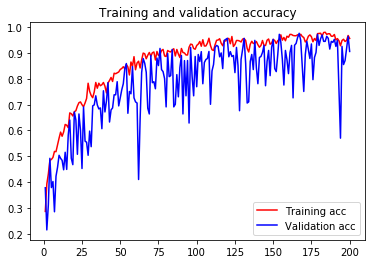

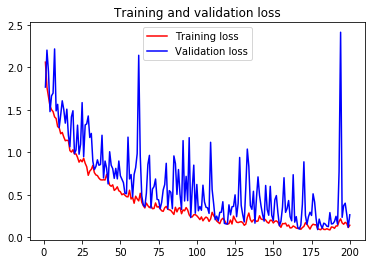

In [30]:
visualized_history(history)

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, BatchNormalization, GlobalAvgPool2D, Input

In [51]:
def get_net1(num_classes):
    from keras.models import Sequential
    from keras.layers import Conv2D, Activation, BatchNormalization, GlobalAvgPool2D, MaxPooling2D, Dropout

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (1, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(num_classes, (1, 1)))
    model.add(GlobalAvgPool2D())
    model.add(Activation('softmax'))
    return model

num_classes = 10
net1 = get_net1(num_classes)
net1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
net1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
activation_140 (Activation)  (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_141 (Activation)  (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
__________

In [52]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath=("models/monkey.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

epochs = 200

history1 = net1.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/200
17/17 [==============================] - 44s 3s/step - loss: 2.0388 - acc: 0.2656 - val_loss: 2.0560 - val_acc: 0.2422

Epoch 00001: val_acc improved from -inf to 0.24219, saving model to models/monkey.h5f
Epoch 2/200
17/17 [==============================] - 30s 2s/step - loss: 1.7711 - acc: 0.3528 - val_loss: 1.9799 - val_acc: 0.3134

Epoch 00002: val_acc improved from 0.24219 to 0.31343, saving model to models/monkey.h5f
Epoch 3/200
17/17 [==============================] - 43s 3s/step - loss: 1.6010 - acc: 0.4236 - val_loss: 2.5759 - val_acc: 0.2930

Epoch 00003: val_acc did not improve from 0.31343
Epoch 4/200
17/17 [==============================] - 40s 2s/step - loss: 1.5304 - acc: 0.5073 - val_loss: 2.0160 - val_acc: 0.3281

Epoch 00004: val_acc improved from 0.31343 to 0.32812, saving model to models/monkey.h5f
Epoch 5/200
17/17 [==============================] - 40s 2s/step - loss: 1.5304 - acc: 0.4671 - val_loss: 1.7722 - val_acc: 0.4258

Epoch 00005: val_acc impro

17/17 [==============================] - 40s 2s/step - loss: 0.7820 - acc: 0.7289 - val_loss: 1.4963 - val_acc: 0.5703

Epoch 00043: val_acc did not improve from 0.69922
Epoch 44/200
17/17 [==============================] - 34s 2s/step - loss: 0.7874 - acc: 0.7203 - val_loss: 1.0473 - val_acc: 0.6211

Epoch 00044: val_acc did not improve from 0.69922
Epoch 45/200
17/17 [==============================] - 39s 2s/step - loss: 0.8772 - acc: 0.6988 - val_loss: 1.0733 - val_acc: 0.6219

Epoch 00045: val_acc did not improve from 0.69922
Epoch 46/200
17/17 [==============================] - 36s 2s/step - loss: 0.7455 - acc: 0.7513 - val_loss: 1.0216 - val_acc: 0.6406

Epoch 00046: val_acc did not improve from 0.69922
Epoch 47/200
17/17 [==============================] - 38s 2s/step - loss: 0.8009 - acc: 0.7133 - val_loss: 0.9762 - val_acc: 0.6250

Epoch 00047: val_acc did not improve from 0.69922
Epoch 48/200
17/17 [==============================] - 38s 2s/step - loss: 0.8653 - acc: 0.7062 - v

17/17 [==============================] - 37s 2s/step - loss: 0.3029 - acc: 0.8935 - val_loss: 0.3575 - val_acc: 0.8789

Epoch 00130: val_acc did not improve from 0.92578
Epoch 131/200
17/17 [==============================] - 37s 2s/step - loss: 0.2180 - acc: 0.9281 - val_loss: 0.3689 - val_acc: 0.8984

Epoch 00131: val_acc did not improve from 0.92578
Epoch 132/200
17/17 [==============================] - 38s 2s/step - loss: 0.2196 - acc: 0.9320 - val_loss: 0.4296 - val_acc: 0.8633

Epoch 00132: val_acc did not improve from 0.92578
Epoch 133/200
17/17 [==============================] - 37s 2s/step - loss: 0.2053 - acc: 0.9301 - val_loss: 0.1659 - val_acc: 0.9453

Epoch 00133: val_acc improved from 0.92578 to 0.94531, saving model to models/monkey.h5f
Epoch 134/200
17/17 [==============================] - 33s 2s/step - loss: 0.2751 - acc: 0.9154 - val_loss: 0.5333 - val_acc: 0.8756

Epoch 00134: val_acc did not improve from 0.94531
Epoch 135/200
17/17 [==============================] - 

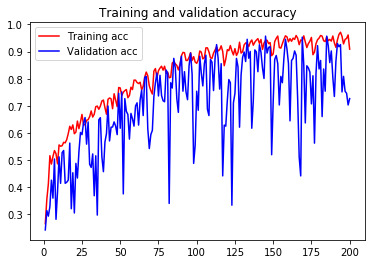

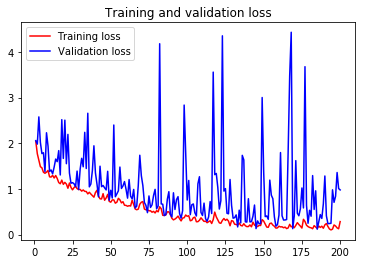

In [53]:
visualized_history(history1)

In [54]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

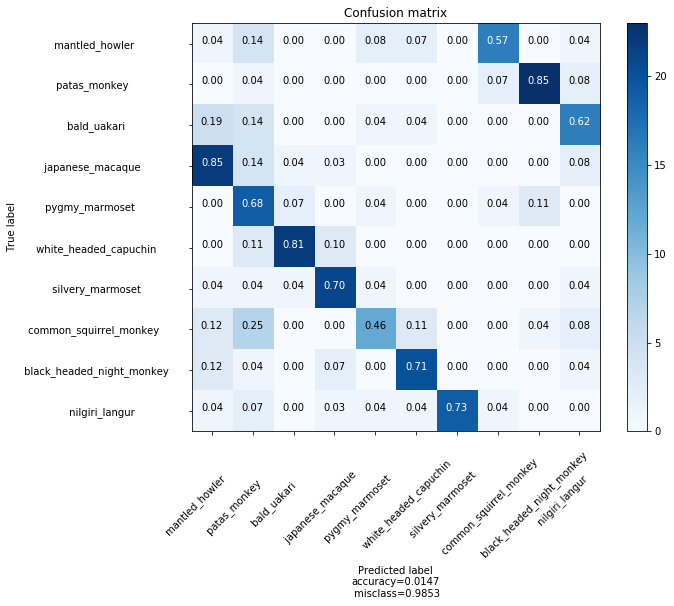

In [55]:
import itertools
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [56]:
from sklearn import metrics
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.03      0.04      0.03        26
 patas_monkey                         0.02      0.04      0.03        28
 bald_uakari                          0.00      0.00      0.00        27
 japanese_macaque                     0.04      0.03      0.03        30
 pygmy_marmoset                       0.06      0.04      0.05        26
 white_headed_capuchin                0.00      0.00      0.00        28
 silvery_marmoset                     0.00      0.00      0.00        26
 common_squirrel_monkey               0.00      0.00      0.00        28
 black_headed_night_monkey            0.00      0.00      0.00        27
 nilgiri_langur                       0.00      0.00      0.00        26

                      micro avg       0.01      0.01      0.01       272
                      macro avg       0.01      0.01      0.01       272
                   weighted avg       0.01      0

In [60]:
def get_net2(num_classes):
    from keras.models import Sequential
    from keras.layers import Conv2D, Activation, BatchNormalization, GlobalAvgPool2D, MaxPooling2D, Dropout

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), strides=2))
    model.add(Activation('relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=2))
    model.add(Activation('relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=2))
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(num_classes, (1, 1)))
    model.add(GlobalAvgPool2D())
    model.add(Activation('softmax'))
    return model

num_classes = 10
net2 = get_net2(num_classes)
net2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
net2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 74, 74, 32)        896       
_________________________________________________________________
activation_152 (Activation)  (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_119 (Bat (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 36, 36, 32)        9248      
_________________________________________________________________
activation_153 (Activation)  (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_120 (Bat (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 34, 34, 64)        18496     
__________

In [61]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath=("models/monkey1.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

epochs = 200

history2 = net2.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/200
17/17 [==============================] - 52s 3s/step - loss: 2.0558 - acc: 0.2646 - val_loss: 1.7347 - val_acc: 0.3633

Epoch 00001: val_acc improved from -inf to 0.36328, saving model to models/monkey1.h5f
Epoch 2/200
17/17 [==============================] - 34s 2s/step - loss: 1.7602 - acc: 0.3501 - val_loss: 1.8536 - val_acc: 0.3438

Epoch 00002: val_acc did not improve from 0.36328
Epoch 3/200
17/17 [==============================] - 34s 2s/step - loss: 1.6544 - acc: 0.3791 - val_loss: 1.7593 - val_acc: 0.3906

Epoch 00003: val_acc improved from 0.36328 to 0.39062, saving model to models/monkey1.h5f
Epoch 4/200
17/17 [==============================] - 44s 3s/step - loss: 1.6077 - acc: 0.4395 - val_loss: 1.9348 - val_acc: 0.3438

Epoch 00004: val_acc did not improve from 0.39062
Epoch 5/200
17/17 [==============================] - 48s 3s/step - loss: 1.5244 - acc: 0.4621 - val_loss: 1.5963 - val_acc: 0.4062

Epoch 00005: val_acc improved from 0.39062 to 0.40625, saving m

17/17 [==============================] - 57s 3s/step - loss: 0.8410 - acc: 0.7142 - val_loss: 0.7709 - val_acc: 0.7266

Epoch 00044: val_acc improved from 0.63672 to 0.72656, saving model to models/monkey1.h5f
Epoch 45/200
17/17 [==============================] - 55s 3s/step - loss: 0.9055 - acc: 0.6935 - val_loss: 0.9271 - val_acc: 0.6758

Epoch 00045: val_acc did not improve from 0.72656
Epoch 46/200
17/17 [==============================] - 56s 3s/step - loss: 0.9551 - acc: 0.6663 - val_loss: 2.0283 - val_acc: 0.4876

Epoch 00046: val_acc did not improve from 0.72656
Epoch 47/200
17/17 [==============================] - 61s 4s/step - loss: 0.9600 - acc: 0.6852 - val_loss: 1.0954 - val_acc: 0.6055

Epoch 00047: val_acc did not improve from 0.72656
Epoch 48/200
17/17 [==============================] - 61s 4s/step - loss: 0.9392 - acc: 0.6628 - val_loss: 1.5836 - val_acc: 0.5234

Epoch 00048: val_acc did not improve from 0.72656
Epoch 49/200
17/17 [==============================] - 56s 

17/17 [==============================] - 54s 3s/step - loss: 0.5459 - acc: 0.8159 - val_loss: 0.6651 - val_acc: 0.7811

Epoch 00088: val_acc did not improve from 0.85547
Epoch 89/200
17/17 [==============================] - 54s 3s/step - loss: 0.4980 - acc: 0.8331 - val_loss: 0.6864 - val_acc: 0.7910

Epoch 00089: val_acc did not improve from 0.85547
Epoch 90/200
17/17 [==============================] - 53s 3s/step - loss: 0.4164 - acc: 0.8470 - val_loss: 0.5297 - val_acc: 0.8125

Epoch 00090: val_acc did not improve from 0.85547
Epoch 91/200
17/17 [==============================] - 57s 3s/step - loss: 0.4950 - acc: 0.8207 - val_loss: 1.0923 - val_acc: 0.6836

Epoch 00091: val_acc did not improve from 0.85547
Epoch 92/200
17/17 [==============================] - 53s 3s/step - loss: 0.4845 - acc: 0.8391 - val_loss: 0.6949 - val_acc: 0.7422

Epoch 00092: val_acc did not improve from 0.85547
Epoch 93/200
17/17 [==============================] - 56s 3s/step - loss: 0.4317 - acc: 0.8599 - v

17/17 [==============================] - 55s 3s/step - loss: 0.4210 - acc: 0.8511 - val_loss: 1.6605 - val_acc: 0.6172

Epoch 00132: val_acc did not improve from 0.89844
Epoch 133/200
17/17 [==============================] - 39s 2s/step - loss: 0.3909 - acc: 0.8702 - val_loss: 0.5622 - val_acc: 0.8320

Epoch 00133: val_acc did not improve from 0.89844
Epoch 134/200
17/17 [==============================] - 36s 2s/step - loss: 0.2813 - acc: 0.9115 - val_loss: 0.4016 - val_acc: 0.8594

Epoch 00134: val_acc did not improve from 0.89844
Epoch 135/200
17/17 [==============================] - 34s 2s/step - loss: 0.3288 - acc: 0.8932 - val_loss: 0.3003 - val_acc: 0.9297

Epoch 00135: val_acc improved from 0.89844 to 0.92969, saving model to models/monkey1.h5f
Epoch 136/200
17/17 [==============================] - 36s 2s/step - loss: 0.3128 - acc: 0.9099 - val_loss: 0.3272 - val_acc: 0.9023

Epoch 00136: val_acc did not improve from 0.92969
Epoch 137/200
17/17 [==============================] -

17/17 [==============================] - 37s 2s/step - loss: 0.2442 - acc: 0.9237 - val_loss: 0.2222 - val_acc: 0.9258

Epoch 00176: val_acc did not improve from 0.94141
Epoch 177/200
17/17 [==============================] - 33s 2s/step - loss: 0.1709 - acc: 0.9457 - val_loss: 0.2757 - val_acc: 0.8945

Epoch 00177: val_acc did not improve from 0.94141
Epoch 178/200
17/17 [==============================] - 37s 2s/step - loss: 0.2177 - acc: 0.9302 - val_loss: 0.3892 - val_acc: 0.8672

Epoch 00178: val_acc did not improve from 0.94141
Epoch 179/200
17/17 [==============================] - 37s 2s/step - loss: 0.2479 - acc: 0.9138 - val_loss: 0.5167 - val_acc: 0.8555

Epoch 00179: val_acc did not improve from 0.94141
Epoch 180/200
17/17 [==============================] - 36s 2s/step - loss: 0.3318 - acc: 0.8965 - val_loss: 0.5362 - val_acc: 0.8281

Epoch 00180: val_acc did not improve from 0.94141
Epoch 181/200
17/17 [==============================] - 37s 2s/step - loss: 0.3237 - acc: 0.896

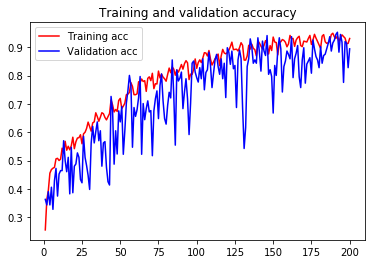

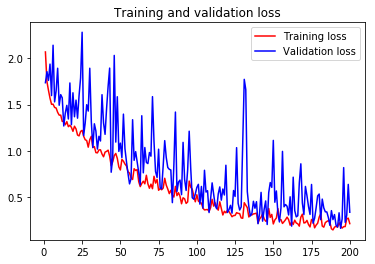

In [63]:
visualized_history(history2)

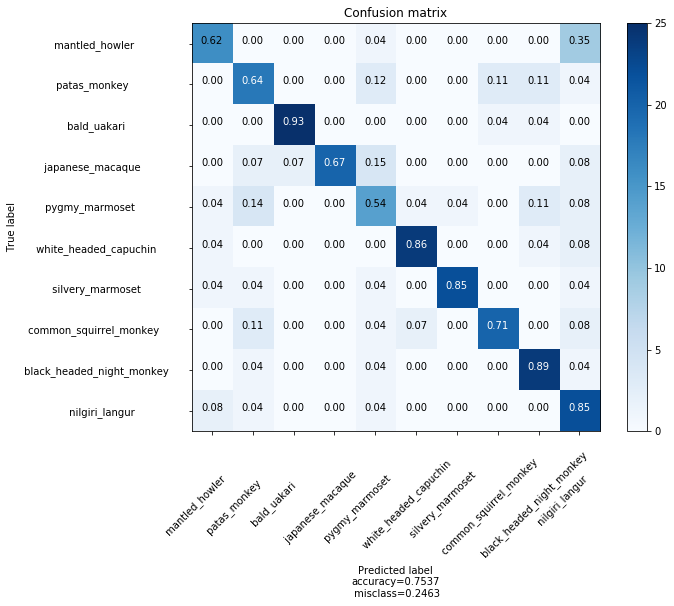

In [65]:
import itertools
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
filepath=("models/monkey1.h5f")
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [66]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.76      0.62      0.68        26
 patas_monkey                         0.60      0.64      0.62        28
 bald_uakari                          0.93      0.93      0.93        27
 japanese_macaque                     1.00      0.67      0.80        30
 pygmy_marmoset                       0.54      0.54      0.54        26
 white_headed_capuchin                0.89      0.86      0.87        28
 silvery_marmoset                     0.96      0.85      0.90        26
 common_squirrel_monkey               0.83      0.71      0.77        28
 black_headed_night_monkey            0.75      0.89      0.81        27
 nilgiri_langur                       0.52      0.85      0.65        26

                      micro avg       0.75      0.75      0.75       272
                      macro avg       0.78      0.75      0.76       272
                   weighted avg       0.78      0